In [42]:
import pprint
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# VARIABLES CONFIGURATION
experiment_id = "06-07-test"

In [4]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

client.admin.command('ping')

{'ok': 1.0}

In [41]:
db = client.test
historical_evolution_data = db.historicalEvolutionData

data = historical_evolution_data.find({"experimentId" : experiment_id})

def convert_cost_values_to_percentages(costs):
    percentage_values = []
    start_value = costs[0]
    for i in range(0, len(costs)):
        percentage_values.append(costs[i] / start_value * 100)
    return percentage_values

def convert_to_percentages(array):
    for i in range(0, len(array)):
        array[i] = convert_cost_values_to_percentages(array[i])


cost_data = list(map(lambda x: x["costData"], data))
convert_to_percentages(cost_data)
percentages = np.array(cost_data)
average_percentages = np.mean(percentages, axis=0)


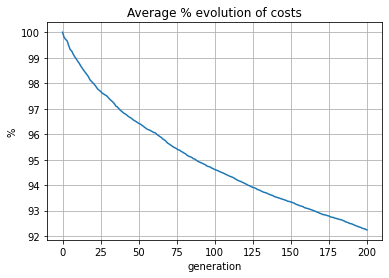

In [45]:
fig, ax = plt.subplots()
ax.plot(average_percentages)

ax.set(xlabel='generation', ylabel='%',
       title='Average % evolution of costs')
ax.grid()

plt.show()